In [6]:
# Install missing dependencies in Colab
!pip install transformers gradio seaborn matplotlib wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from transformers import (RobertaTokenizer, RobertaForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)
import torch
import gradio as gr
import os
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


In [3]:
# Load Dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_json(next(iter(uploaded))).T  # Load JSON file

Saving sarcasm_data.json to sarcasm_data.json


In [4]:
# Updated cleaning function (no need to preserve emojis)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation (and emojis, if any)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply Cleaning
df['utterance'] = df['utterance'].apply(clean_text)
df['context'] = df['context'].apply(lambda x: [clean_text(c) for c in x])
df = df[['utterance', 'context', 'sarcasm']]


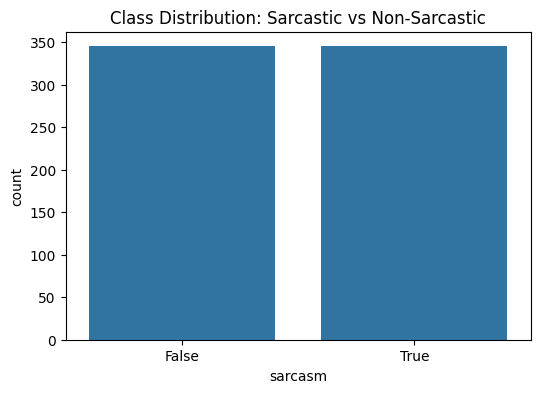

In [5]:
# Visualize class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['sarcasm'])
plt.title("Class Distribution: Sarcastic vs Non-Sarcastic")
plt.show()

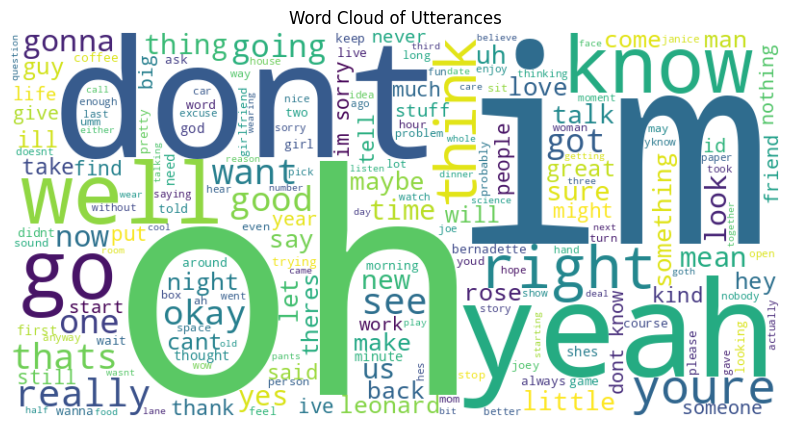

In [7]:
# Generate and display a word cloud for all utterances
all_text = " ".join(df['utterance'])
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Utterances")
plt.show()

In [6]:
# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define a custom dataset class
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert to long tensor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get predictions
    # labels = labels.numpy()  # Remove this line - labels are already a NumPy array

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    cm = confusion_matrix(labels, predictions)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(labels, predictions))

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Sarcastic', 'Sarcastic'],
                yticklabels=['Non-Sarcastic', 'Sarcastic'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        "eval_accuracy": float(acc),
        "eval_precision": float(precision),
        "eval_recall": float(recall),
        "eval_f1": float(f1)
    }

In [22]:
# Set up cross-validation with 3 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)
all_metrics = []

# Define training arguments with hyperparameter tuning & regularization
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="steps",
    logging_strategy="steps",
    logging_steps=500,
    evaluation_strategy="steps",
    logging_dir="./logs",
    eval_steps=500,
    report_to="wandb",         # Enable W&B logging (ensure you have logged in)
    weight_decay=0.01,         # Regularization
    max_grad_norm=1.0,         # Gradient clipping
    load_best_model_at_end=True,    # Required for EarlyStoppingCallback
    metric_for_best_model="eval_loss"  # Monitor evaluation loss
)

# Ensure fold counter starts correctly
for fold, (train_index, val_index) in enumerate(kf.split(df), start=1):
    print(f"\n----- Fold {fold} -----")
    print(f"Fold {fold} - Training samples: {len(train_index)}, Validation samples: {len(val_index)}")

    train_texts = df.iloc[train_index]['utterance']
    train_labels = df.iloc[train_index]['sarcasm']
    val_texts = df.iloc[val_index]['utterance']
    val_labels = df.iloc[val_index]['sarcasm']

    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

    train_dataset = SarcasmDataset(train_encodings, train_labels.tolist())
    val_dataset = SarcasmDataset(val_encodings, val_labels.tolist())

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



----- Fold 1 -----
Fold 1 - Training samples: 460, Validation samples: 230

----- Fold 2 -----
Fold 2 - Training samples: 460, Validation samples: 230

----- Fold 3 -----
Fold 3 - Training samples: 460, Validation samples: 230



----- Fold 1 -----
Fold 1 - Training samples: 460, Validation samples: 230


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Confusion Matrix:
 [[63 41]
 [46 80]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.61      0.59       104
           1       0.66      0.63      0.65       126

    accuracy                           0.62       230
   macro avg       0.62      0.62      0.62       230
weighted avg       0.62      0.62      0.62       230



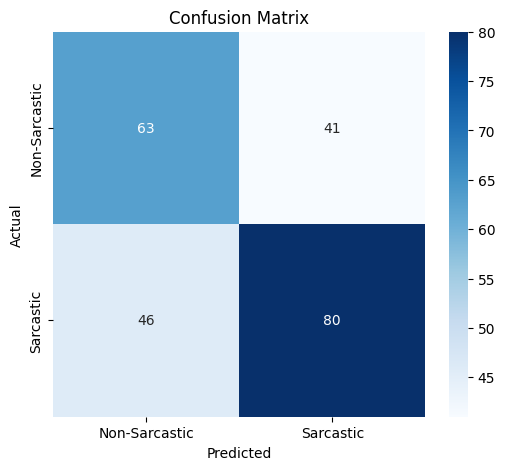

Metrics for Fold 1: {'eval_accuracy': 0.6217391304347826, 'eval_precision': 0.6611570247933884, 'eval_recall': 0.6349206349206349, 'eval_f1': 0.6477732793522267, 'eval_loss': 0.690780758857727, 'eval_runtime': 34.9016, 'eval_samples_per_second': 6.59, 'eval_steps_per_second': 0.831, 'epoch': 3.0}

----- Fold 2 -----
Fold 2 - Training samples: 460, Validation samples: 230


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Confusion Matrix:
 [[43 74]
 [32 81]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.37      0.45       117
           1       0.52      0.72      0.60       113

    accuracy                           0.54       230
   macro avg       0.55      0.54      0.53       230
weighted avg       0.55      0.54      0.52       230



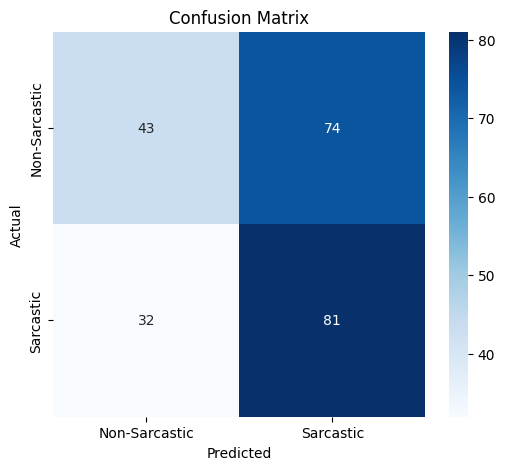

Metrics for Fold 2: {'eval_accuracy': 0.5391304347826087, 'eval_precision': 0.5225806451612903, 'eval_recall': 0.7168141592920354, 'eval_f1': 0.6044776119402985, 'eval_loss': 0.6824259757995605, 'eval_runtime': 53.0813, 'eval_samples_per_second': 4.333, 'eval_steps_per_second': 0.546, 'epoch': 3.0}

----- Fold 3 -----
Fold 3 - Training samples: 460, Validation samples: 230


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Confusion Matrix:
 [[88 36]
 [49 57]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.71      0.67       124
           1       0.61      0.54      0.57       106

    accuracy                           0.63       230
   macro avg       0.63      0.62      0.62       230
weighted avg       0.63      0.63      0.63       230



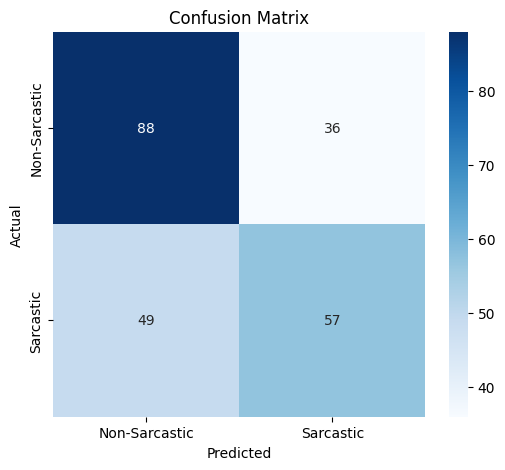

Metrics for Fold 3: {'eval_accuracy': 0.6304347826086957, 'eval_precision': 0.6129032258064516, 'eval_recall': 0.5377358490566038, 'eval_f1': 0.5728643216080402, 'eval_loss': 0.7677341103553772, 'eval_runtime': 37.5119, 'eval_samples_per_second': 6.131, 'eval_steps_per_second': 0.773, 'epoch': 3.0}


In [23]:
# Create a new model for each fold outside the loop

for fold, (train_index, val_index) in enumerate(kf.split(df), start=1):
    print(f"\n----- Fold {fold} -----")
    print(f"Fold {fold} - Training samples: {len(train_index)}, Validation samples: {len(val_index)}")

    train_texts = df.iloc[train_index]['utterance']
    train_labels = df.iloc[train_index]['sarcasm']
    val_texts = df.iloc[val_index]['utterance']
    val_labels = df.iloc[val_index]['sarcasm']

    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

    train_dataset = SarcasmDataset(train_encodings, train_labels.tolist())
    val_dataset = SarcasmDataset(val_encodings, val_labels.tolist())
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2) # Correct indentation

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train(resume_from_checkpoint=False)
    fold_metrics = trainer.evaluate()
    print(f"Metrics for Fold {fold}: {fold_metrics}")
    all_metrics.append(fold_metrics)

In [24]:
# Compute average metrics across folds
avg_accuracy = np.mean([m["eval_accuracy"] for m in all_metrics])
avg_precision = np.mean([m["eval_precision"] for m in all_metrics])
avg_recall = np.mean([m["eval_recall"] for m in all_metrics])
avg_f1 = np.mean([m["eval_f1"] for m in all_metrics])

print(f"\nAverage Metrics Across Folds:\n Accuracy: {avg_accuracy}\n Precision: {avg_precision}\n Recall: {avg_recall}\n F1: {avg_f1}")



Average Metrics Across Folds:
 Accuracy: 0.5971014492753622
 Precision: 0.5988802985870434
 Recall: 0.6298235477564247
 F1: 0.6083717376335218


In [22]:
# Train a final model on the entire dataset for deployment
print("\nTraining final model on the entire dataset for deployment...")

# Prepare the entire dataset for final training
all_texts = df['utterance']
all_labels = df['sarcasm']
all_encodings = tokenizer(list(all_texts), truncation=True, padding=True, max_length=128)
final_dataset = SarcasmDataset(all_encodings, all_labels.tolist())

# Split the final dataset into train and evaluation sets
from sklearn.model_selection import train_test_split
train_dataset, eval_dataset = train_test_split(final_dataset, test_size=0.2, random_state=42)  # 20% for evaluation


# Set final training arguments with tuned hyperparameters
final_training_args = TrainingArguments(
    output_dir='./final_results',
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=2,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    report_to="wandb",                     # Enable W&B logging (ensure you've run !wandb login)
    weight_decay=0.02,                     # Increased weight decay for regularization
    max_grad_norm=1.0,
    learning_rate=3e-5,                    # Lower learning rate for more stable training
    load_best_model_at_end=True,           # Load the best model at the end of training
    metric_for_best_model="eval_loss",      # Use evaluation loss to select the best model
    save_strategy="epoch"                  # Changed to "epoch" to match evaluation_strategy
)

# Initialize the final model from the base checkpoint
final_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Create a Trainer for the final model (no early stopping needed without evaluation)
final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=train_dataset,  # Pass the training dataset
    eval_dataset=eval_dataset     # Pass the evaluation dataset
)

# Train the final model
final_trainer.train(resume_from_checkpoint=False)

# Save the final model and tokenizer for deployment
final_model.save_pretrained("sarcasm_roberta_final_model")
tokenizer.save_pretrained("sarcasm_roberta_final_model")


Training final model on the entire dataset for deployment...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,No log,0.799458
2,No log,0.746724
3,No log,0.961592


('sarcasm_roberta_final_model/tokenizer_config.json',
 'sarcasm_roberta_final_model/special_tokens_map.json',
 'sarcasm_roberta_final_model/vocab.json',
 'sarcasm_roberta_final_model/merges.txt',
 'sarcasm_roberta_final_model/added_tokens.json')

In [23]:
metrics = final_trainer.evaluate()
print(metrics)

{'eval_loss': 0.7467243075370789, 'eval_runtime': 39.7342, 'eval_samples_per_second': 3.473, 'eval_steps_per_second': 0.453, 'epoch': 3.0}


Confusion Matrix:
 [[31 22]
 [26 59]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.58      0.56        53
           1       0.73      0.69      0.71        85

    accuracy                           0.65       138
   macro avg       0.64      0.64      0.64       138
weighted avg       0.66      0.65      0.65       138



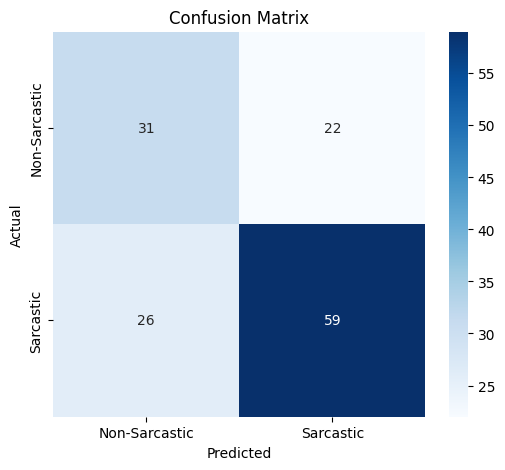

{'eval_accuracy': 0.6521739130434783, 'eval_precision': 0.7283950617283951, 'eval_recall': 0.6941176470588235, 'eval_f1': 0.7108433734939759, 'eval_loss': 0.7467243075370789, 'eval_model_preparation_time': 0.0037, 'eval_runtime': 22.8693, 'eval_samples_per_second': 6.034, 'eval_steps_per_second': 0.787}


In [24]:
# ipython-input-10-c0ad97b481b2 (updated)
from transformers import TrainingArguments, Trainer  # Make sure these are imported

# Prepare the entire dataset for final training (same as in ipython-input-8-c0ad97b481b2)
all_texts = df['utterance']
all_labels = df['sarcasm']
all_encodings = tokenizer(list(all_texts), truncation=True, padding=True, max_length=128)
final_dataset = SarcasmDataset(all_encodings, all_labels.tolist())

# Split the final dataset into train and evaluation sets (same as in previous solution)
from sklearn.model_selection import train_test_split
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=42  # 20% for evaluation
)

eval_encodings = tokenizer(list(eval_texts), truncation=True, padding=True, max_length=128)
final_eval_dataset = SarcasmDataset(eval_encodings, eval_labels.tolist())

# Load the pretrained model and tokenizer
model_path = "/content/sarcasm_roberta_final_model" # The path where you saved your model
final_model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

# Set up training arguments (only for evaluation)
eval_training_args = TrainingArguments(
    output_dir='./eval_results',  # You can change this directory if needed
    per_device_eval_batch_size=8,
    # ... other arguments you might need for evaluation
)

# Create a Trainer for evaluation
eval_trainer = Trainer(
    model=final_model,
    args=eval_training_args,
    eval_dataset=final_eval_dataset,
    compute_metrics=compute_metrics
)

# Evaluate the model
metrics = eval_trainer.evaluate()
print(metrics)

In [25]:
# Define a testing function for deployment
def test_model(text):
    inputs = tokenizer(text, return_tensors="pt")
    output = final_model(**inputs)
    return "Sarcastic" if output.logits.argmax() == 1 else "Non-Sarcastic"